# Unsupervised Learning and Dimensionality Reduction

### Importing Necessary Libraries


In [1]:
%matplotlib inline
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import sklearn
import warnings
import matplotlib
import numpy as np
import mlrose_hiive
import pandas as pd
import seaborn as sns
from time import clock
from matplotlib import cm
from functools import partial
from sklearn.base import clone
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import preprocessing
from mlrose_hiive import ExpDecay
from sklearn.cluster import KMeans
from statistics import mean, stdev
from IPython.display import display 
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LassoCV
from sklearn.mixture import GaussianMixture
from collections import defaultdict, Counter
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import SelectFromModel
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA, FactorAnalysis, FastICA, NMF
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, adjusted_mutual_info_score, f1_score,homogeneity_score, accuracy_score, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, StratifiedShuffleSplit, validation_curve, learning_curve
from sklearn.metrics import roc_curve, precision_score, accuracy_score, average_precision_score, recall_score, f1_score, classification_report, confusion_matrix
np.random.seed(44)


### Setting Graph Format Defaults

In [2]:
# Specify printing and plot dimensions 
pd.options.display.max_columns = None
matplotlib.rc('figure', figsize=[10,5])

# Initializing Random Seed to make experiments reproducible
np.random.seed(1126)

# setting config to print all parameters
set_config(print_changed_only=False)

### Uploading Data Preprocessing (Normalizing and Assigning Features and Target variables)

In [33]:
# Upload credit Dataset
creditdata = pd.read_csv('creditdata.csv')
creditdata = creditdata.iloc[: , 1:]
newheader = list(creditdata.loc[0])
creditdata = creditdata.drop(labels=0, axis=0)
creditdata.columns = newheader
creditdata.reset_index(inplace=True)
creditdata = creditdata.astype('float64')
# creditdata.head()

#split Credit dataset in features and target variable
credit_feature_cols = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
creditX = creditdata.reindex(columns =credit_feature_cols) # Features
creditX_df = creditX
# print('creditX head')
# print(creditX.head())
# print(creditX.info())
# print()
creditY = creditdata.reindex(columns =['default payment next month']) # Target variable
# print( 'CreditY Value Counts before replacement')
# print(creditY.value_counts())
# print()
# All the credit non-defaulters = 1, all the credit defaulters= -1
creditY = creditY.replace(['0','1'], [1,-1],regex=True)
creditY = creditY.astype('int64')
# print( 'CreditY Value Counts after replacement')
# print(creditY.value_counts())
# print()

creditdata_concat = pd.concat([creditX, creditY], axis=1)
intcols_2 = list(creditdata_concat.columns[creditdata_concat.dtypes.eq('string')])
creditdata_concat[intcols_2] = creditdata_concat[intcols_2].astype(float)
creditdata_concat = creditdata_concat.rename(columns={"default payment next month":"default_payment_next_month"})

# Normalize Features
min_max_scaler = preprocessing.MinMaxScaler()
creditX = min_max_scaler.fit_transform(creditX)

### Initializing Cluster Object and plotting SSE against # Of Clusters (SSE Metric Elbow Method)

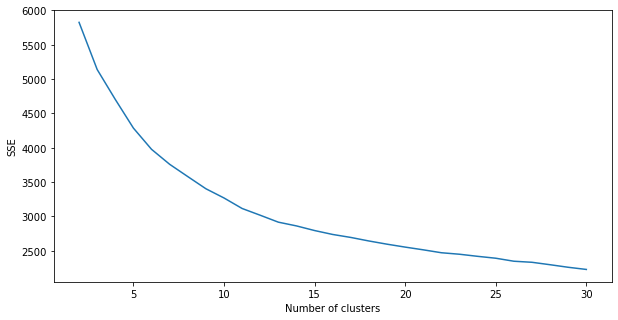

In [4]:
clusters = list(range(2,31,1))

sse = {}
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, max_iter=1000, random_state=44, n_jobs=-2).fit(creditX)
    sse[cluster] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

### Comparing Cluster Against Existing Classes

In [5]:
kmeans = KMeans(n_clusters=2, n_init=150, max_iter=1000, random_state=44, n_jobs=-2).fit(creditX)
accuracy_score((1-kmeans.labels_), creditY)

0.42593333333333333

### Calculate Silhuette and homogenity scores

In [40]:
creditY = creditY.squeeze()
creditY.shape

(30000,)

For n_clusters=2, The Silhouette Coefficient is 0.5027886041328958
For n_clusters=2, The homogeneity_score is 0.001500777519188931
For n_clusters=3, The Silhouette Coefficient is 0.3048965765544805
For n_clusters=3, The homogeneity_score is 0.006872264458051257
For n_clusters=4, The Silhouette Coefficient is 0.18527705781771403
For n_clusters=4, The homogeneity_score is 0.015579512685178844
For n_clusters=5, The Silhouette Coefficient is 0.19541366356747203
For n_clusters=5, The homogeneity_score is 0.015083076243797422
For n_clusters=6, The Silhouette Coefficient is 0.21067011973713484
For n_clusters=6, The homogeneity_score is 0.0440560866311049
For n_clusters=7, The Silhouette Coefficient is 0.2100645173579309
For n_clusters=7, The homogeneity_score is 0.08629276656483607
For n_clusters=8, The Silhouette Coefficient is 0.20660889889470466
For n_clusters=8, The homogeneity_score is 0.08044577533748444
For n_clusters=9, The Silhouette Coefficient is 0.20225489495388144
For n_clusters=

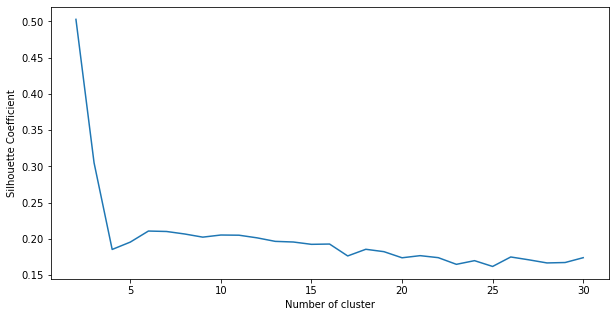

In [7]:
silh = {}
homog = {}
for cluster in range(2, 31, 1):
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=44, 
                    n_jobs=-2).fit(creditX)
    label = kmeans.labels_
    sil_coeff = silhouette_score(creditX, label, metric='euclidean')
    homog_score = homogeneity_score(creditY, label)
    silh[cluster] = sil_coeff
    homog[cluster] = homog_score
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Plot Silhuette and homogenity scores

Text(0, 0.5, 'Silhouette Coefficient')

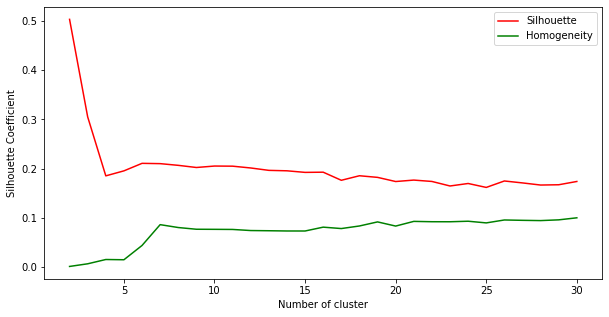

In [8]:
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()), 'r', label="Silhouette")
plt.plot(list(homog.keys()), list(homog.values()), 'g', label="Homogeneity")
plt.legend()
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")

### EXPECTATION MAXIMIZATION

For n_clusters=2, The Silhouette Coefficient is 0.5027886041328958
For n_clusters=2, The homogeneity_score is 0.001500777519188931
For n_clusters=2, The log_likelihood score is 44.26123357556347
For n_clusters=3, The Silhouette Coefficient is 0.21139305401396474
For n_clusters=3, The homogeneity_score is 0.009795656323841311
For n_clusters=3, The log_likelihood score is 51.28795827438997
For n_clusters=4, The Silhouette Coefficient is 0.03205767043383198
For n_clusters=4, The homogeneity_score is 0.015489497893891719
For n_clusters=4, The log_likelihood score is 55.86517101851838
For n_clusters=5, The Silhouette Coefficient is 0.009538545274172309
For n_clusters=5, The homogeneity_score is 0.020151748307937003
For n_clusters=5, The log_likelihood score is 57.11081877314161
For n_clusters=6, The Silhouette Coefficient is 0.08240304280564327
For n_clusters=6, The homogeneity_score is 0.015014397404907112
For n_clusters=6, The log_likelihood score is 59.1197085755721
For n_clusters=7, The

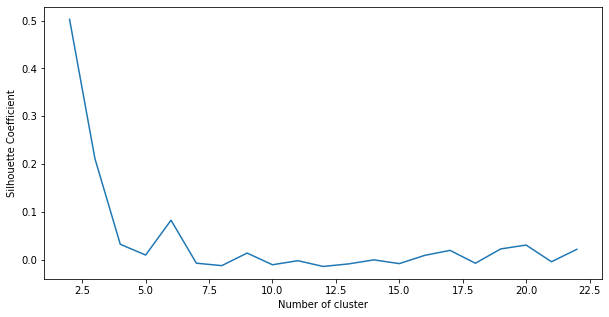

In [9]:
silh_EM = {}
homog_EM = {}
log_likelihood_EM = {}
for cluster in list(range(2,23,1)):
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=44, 
                          n_init=5).fit(creditX)
    label = gmm.predict(creditX)
    sil_coeff = silhouette_score(creditX, label, metric='euclidean')
    homog_score = homogeneity_score(creditY, label)
    silh_EM[cluster] = sil_coeff
    homog_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(creditX)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
    print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_EM[cluster]))

    
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

Text(0, 0.5, 'Silhouette Coefficient')

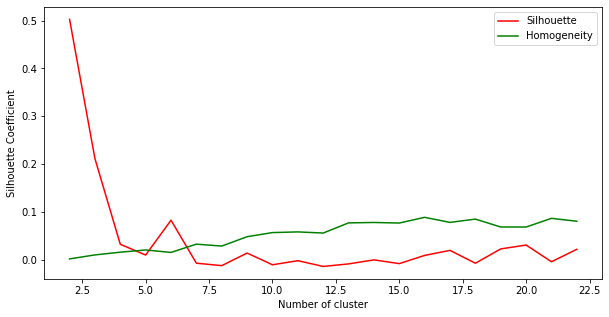

In [10]:
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()), 'r', label="Silhouette")
plt.plot(list(homog_EM.keys()), list(homog_EM.values()), 'g', label="Homogeneity")
plt.legend()
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")

### Comparing EM Cluster Against Existing Classes

In [11]:
gmm = GaussianMixture(n_components=2, max_iter=100, random_state=44, 
                      n_init=5).fit(creditX)
label = gmm.predict(creditX)
accuracy_score((1-label), creditY)

0.42593333333333333

### PCA

In [34]:
dims_credit = list(range(2,23,1))

for dim in dims_credit:
    pca = PCA(n_components=dim, random_state=44)
    pca.fit_transform(creditX)
    
    # reconstruction
    x_prime = pca.fit_transform(creditX)
    A = np.linalg.pinv(pca.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(creditX, reconstructed)    
        
    print(dim, ": ", sum(pca.explained_variance_ratio_), rc_err)


2 :  0.6964800622705273 0.05859065693080748
3 :  0.7904022739803032 0.05681856826890284
4 :  0.8455618207700738 0.05577783886440364
5 :  0.8839247959378359 0.05505402080162423
6 :  0.9166721899058147 0.054436155394697
7 :  0.9380700545764696 0.05403242860119866
8 :  0.956207145741953 0.05369022484524805
9 :  0.9687710243399845 0.053453174349866545
10 :  0.9771386310509677 0.053295297520628254
11 :  0.9833384310033785 0.053178322046970324
12 :  0.9875115316576293 0.05309958556685794
13 :  0.9906108232655139 0.05304110930849164
14 :  0.9931429460461317 0.052993334176407496
15 :  0.9954486759841085 0.05294983053859775
16 :  0.996824394033171 0.05292387401231586
17 :  0.9978175525224451 0.05290513547468681
18 :  0.9986091155659742 0.05289020056345461
19 :  0.9991613442997644 0.052879781321188785
20 :  0.9994913120632745 0.052873555614597445
21 :  0.9997417197558054 0.052868831017245106
22 :  0.9999125435415012 0.05286560797885719


In [35]:
comp = 13
pca = PCA(n_components=comp, random_state=44)
pca_result = pca.fit_transform(creditX)
for i in range(comp):
    field_name = "pca-"+str(i)
    creditX_df[field_name] = pca_result[:,i]
    creditdata_concat[field_name] = pca_result[:,i]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum(pca.explained_variance_ratio_)
creditX_pca_13 = pca_result

Explained variation per principal component: [0.55285284 0.14362722 0.09392221 0.05515955 0.03836298 0.03274739
 0.02139786 0.01813709 0.01256388 0.00836761 0.0061998  0.0041731
 0.00309929]


<AxesSubplot:xlabel='pca-0', ylabel='pca-1'>

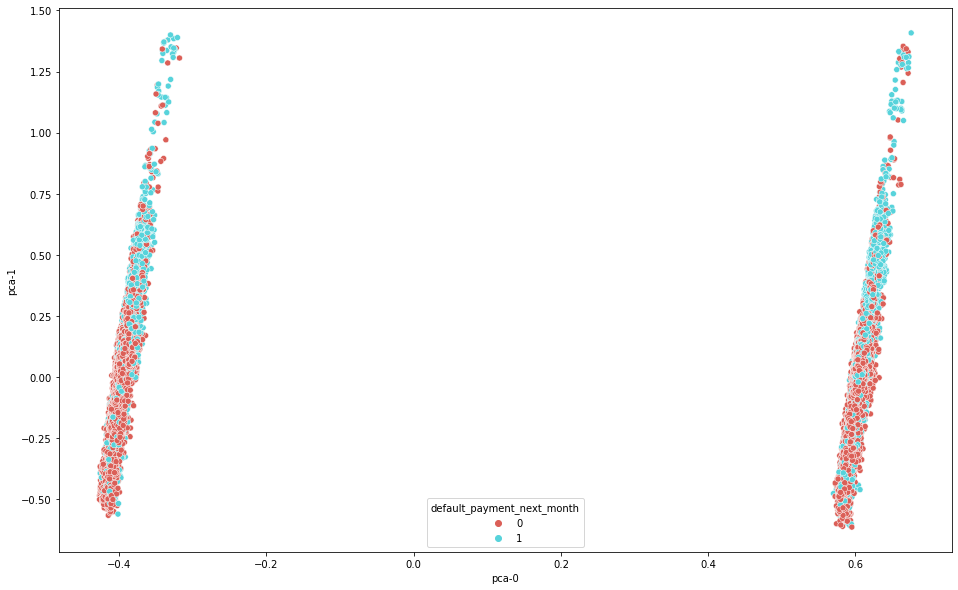

In [36]:
rndperm = np.random.permutation(creditdata_concat.shape[0])
plt.figure(figsize=(16,10))
sns.scatterplot(data=creditdata_concat, x="pca-0", y="pca-1", hue="default_payment_next_month",palette=sns.color_palette("hls",2))

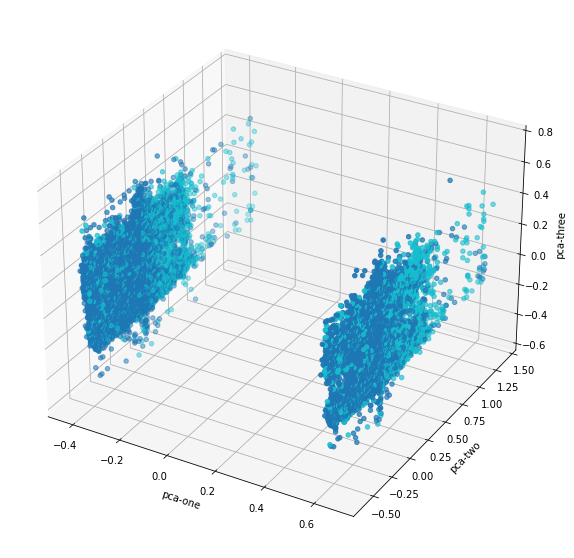

In [37]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=creditdata_concat.loc[rndperm,:]["pca-0"], 
    ys=creditdata_concat.loc[rndperm,:]["pca-1"], 
    zs=creditdata_concat.loc[rndperm,:]["pca-2"], 
    c=creditdata_concat.loc[rndperm,:]["default_payment_next_month"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()


### K-MEANS CLUSTERING AFTER APPLYING PCA

For n_clusters=2, The Silhouette Coefficient is 0.5067427222387926
For n_clusters=2, The homogeneity_score is 0.001500777519188931
For n_clusters=3, The Silhouette Coefficient is 0.308279468373425
For n_clusters=3, The homogeneity_score is 0.006872264458051257
For n_clusters=4, The Silhouette Coefficient is 0.18818245295010355
For n_clusters=4, The homogeneity_score is 0.015538390218947679
For n_clusters=5, The Silhouette Coefficient is 0.19903167971230712
For n_clusters=5, The homogeneity_score is 0.014930911609048537
For n_clusters=6, The Silhouette Coefficient is 0.21482255930289648
For n_clusters=6, The homogeneity_score is 0.043679208694552316
For n_clusters=7, The Silhouette Coefficient is 0.21420877582860315
For n_clusters=7, The homogeneity_score is 0.08596003683130361
For n_clusters=8, The Silhouette Coefficient is 0.21085299751887807
For n_clusters=8, The homogeneity_score is 0.08065190346118382
For n_clusters=9, The Silhouette Coefficient is 0.20670414115570518
For n_cluster

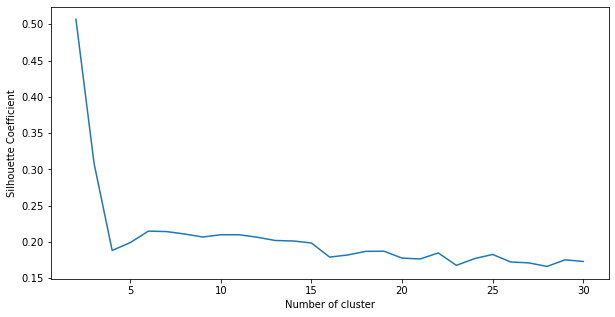

In [41]:
silh = {}
homog = {}
for cluster in range(2, 31, 1):
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=44, 
                    n_jobs=-2).fit(creditX_pca_13)
    label = kmeans.labels_
    sil_coeff = silhouette_score(creditX_pca_13, label, metric='euclidean')
    homog_score = homogeneity_score(creditY, label)
    silh[cluster] = sil_coeff
    homog[cluster] = homog_score
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

### EXPECTATION MAXIMIZATION AFTER APPLYING PCA

For n_clusters=2, The Silhouette Coefficient is 0.5067427222387926
For n_clusters=2, The homogeneity_score is 0.001500777519188931
For n_clusters=2, The log_likelihood score is 16.925736388667683
For n_clusters=3, The Silhouette Coefficient is 0.21055614080624904
For n_clusters=3, The homogeneity_score is 0.010203927442993319
For n_clusters=3, The log_likelihood score is 21.091281177632293
For n_clusters=4, The Silhouette Coefficient is 0.026128840350488933
For n_clusters=4, The homogeneity_score is 0.016145476095603316
For n_clusters=4, The log_likelihood score is 23.774503709100042
For n_clusters=5, The Silhouette Coefficient is 0.18918581044931285
For n_clusters=5, The homogeneity_score is 0.009293163913147384
For n_clusters=5, The log_likelihood score is 23.290500243011696
For n_clusters=6, The Silhouette Coefficient is 0.030647711852895217
For n_clusters=6, The homogeneity_score is 0.03634604767149572
For n_clusters=6, The log_likelihood score is 26.10403423450742
For n_clusters=7

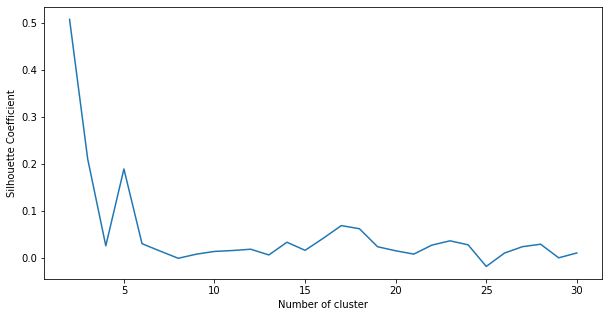

In [42]:
silh_EM = {}
homog_EM = {}
log_likelihood_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=44, 
                          n_init=5).fit(creditX_pca_13)
    label = gmm.predict(creditX_pca_13)
    sil_coeff = silhouette_score(creditX_pca_13, label, metric='euclidean')
    homog_score = homogeneity_score(creditY, label)
    silh_EM[cluster] = sil_coeff
    homog_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(creditX_pca_13)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
    print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_EM[cluster]))

    
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

### HELPER FUNCTION FOR NEURAL NETWORKS

#### Creating Learning Curve Plot Helper Function

In [43]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training instances")
    axes[0].set_ylabel("Score")
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                   train_sizes=train_sizes,
                   return_times=True)
        
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training instances")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

### NEURAL NETWORK AFTER APPLYING PCA

#### SPLIT PCA Data into train and test

In [45]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

creditX_pca_13 = pd.DataFrame(creditX_pca_13, columns = ['Column_A','Column_B','Column_C','Column_D','Column_E','Column_F','Column_G','Column_H','Column_I','Column_J','Column_K','Column_L','Column_M'])
creditY_df = pd.DataFrame(creditY)

# Splitting credit Dataset
sss.get_n_splits(creditX_pca_13, creditY_df)
for train_index, test_index in sss.split(creditX_pca_13, creditY_df):
    creditx_train, creditx_test = creditX_pca_13.loc[train_index], creditX_pca_13.loc[test_index]
    credity_train, credity_test = creditY_df.loc[train_index], creditY_df.loc[test_index]

#### PCA LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

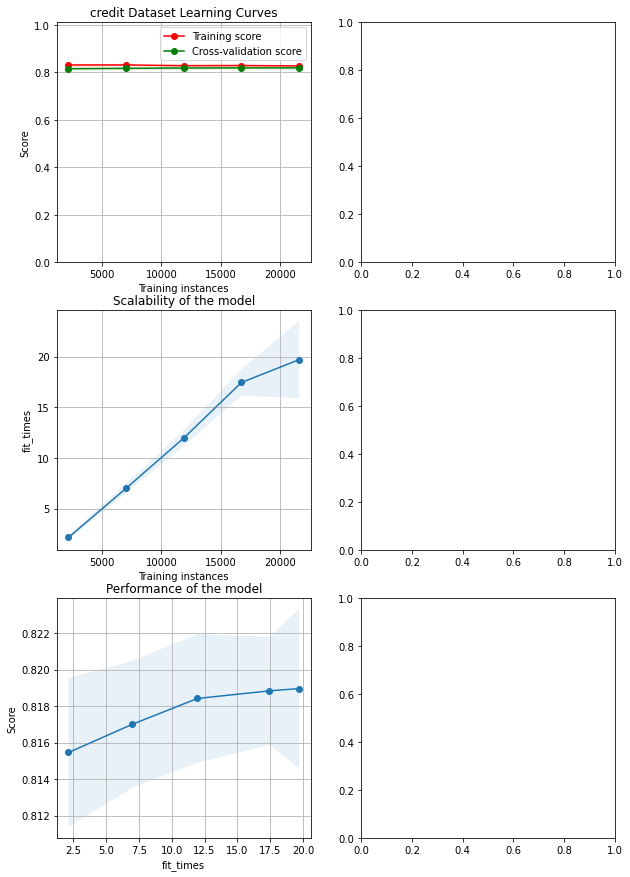

In [46]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = creditx_train, credity_train

title = "credit Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### PCA PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [47]:
# Make Predictions on credit Dataset
print("\n credit Dataset Predictions Results")
best_credit_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_credit_model.fit(creditx_train, credity_train)
credity_predictions = best_credit_model.predict(creditx_test)
print(classification_report(credity_test, credity_predictions,digits=5))
print(confusion_matrix(credity_test, credity_predictions))


 credit Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.84542   0.93516   0.88803      4673
           1    0.63538   0.39789   0.48934      1327

    accuracy                        0.81633      6000
   macro avg    0.74040   0.66652   0.68869      6000
weighted avg    0.79897   0.81633   0.79985      6000

[[4370  303]
 [ 799  528]]


### NEURAL NETWORK AFTER APPLYING PCA AND KMEANS

#### OBTAIN PCA & KMEANS DATA

In [48]:
kmeans = KMeans(n_clusters=22, n_init=50, max_iter=1000, random_state=44, 
                    n_jobs=-2).fit(creditX_pca_13)
label = kmeans.labels_


In [49]:
creditX_pca_kmeans = label.reshape(creditX_pca_13.shape[0],1)
creditX_pca_kmeans = pd.DataFrame(creditX_pca_kmeans)

#### SPLIT PCA & KMEANS Data into train and test

In [50]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting credit Dataset
sss.get_n_splits(creditX_pca_kmeans, creditY)
for train_index, test_index in sss.split(creditX_pca_kmeans, creditY):
    creditx_train, creditx_test = creditX_pca_kmeans.loc[train_index], creditX_pca_kmeans.loc[test_index]
    credity_train, credity_test = creditY.loc[train_index], creditY.loc[test_index]

#### PCA & KMEANS LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

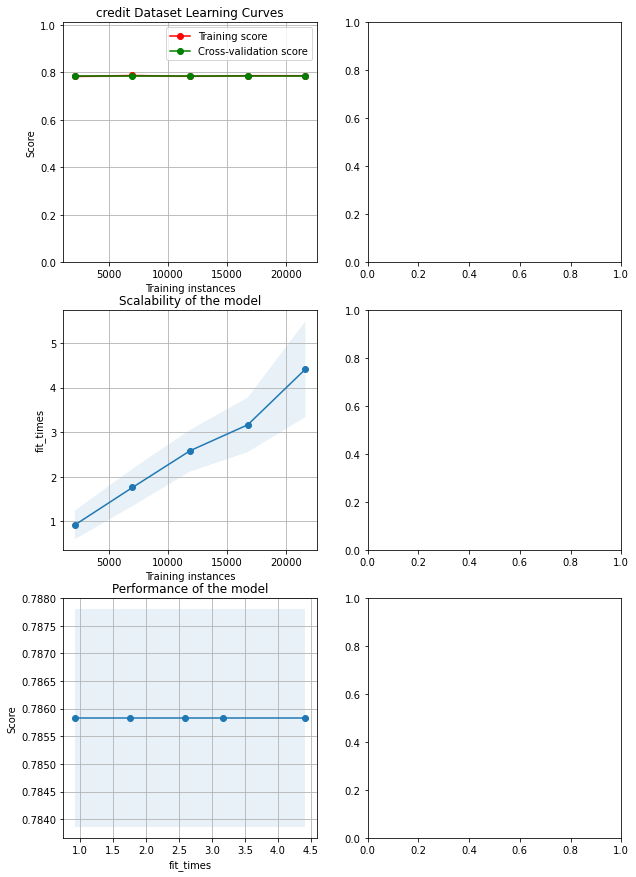

In [51]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = creditx_train, credity_train

title = "credit Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### PCA & KMEANS PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [52]:
# Make Predictions on credit Dataset
print("\n credit Dataset Predictions Results")
best_credit_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_credit_model.fit(creditx_train, credity_train)
credity_predictions = best_credit_model.predict(creditx_test)
print(classification_report(credity_test, credity_predictions,digits=5))
print(confusion_matrix(credity_test, credity_predictions))


 credit Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.79014   0.98780   0.87798      4673
           1    0.63924   0.07611   0.13603      1327

    accuracy                        0.78617      6000
   macro avg    0.71469   0.53196   0.50701      6000
weighted avg    0.75677   0.78617   0.71389      6000

[[4616   57]
 [1226  101]]


### NEURAL NETWORK AFTER APPLYING PCA AND EM

#### OBTAIN PCA & EM DATA

In [53]:
gmm = GaussianMixture(n_components=22, max_iter=100, random_state=44, 
                          n_init=5).fit(creditX_pca_13)
label = gmm.predict(creditX_pca_13)

In [54]:
creditX_pca_em = label.reshape(creditX_pca_13.shape[0],1)
creditX_pca_em = pd.DataFrame(creditX_pca_em)

#### SPLIT PCA & EM Data into train and test

In [55]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting credit Dataset
sss.get_n_splits(creditX_pca_em, creditY)
for train_index, test_index in sss.split(creditX_pca_em, creditY):
    creditx_train, creditx_test = creditX_pca_em.loc[train_index], creditX_pca_em.loc[test_index]
    credity_train, credity_test = creditY.loc[train_index], creditY.loc[test_index]

#### PCA & EM LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

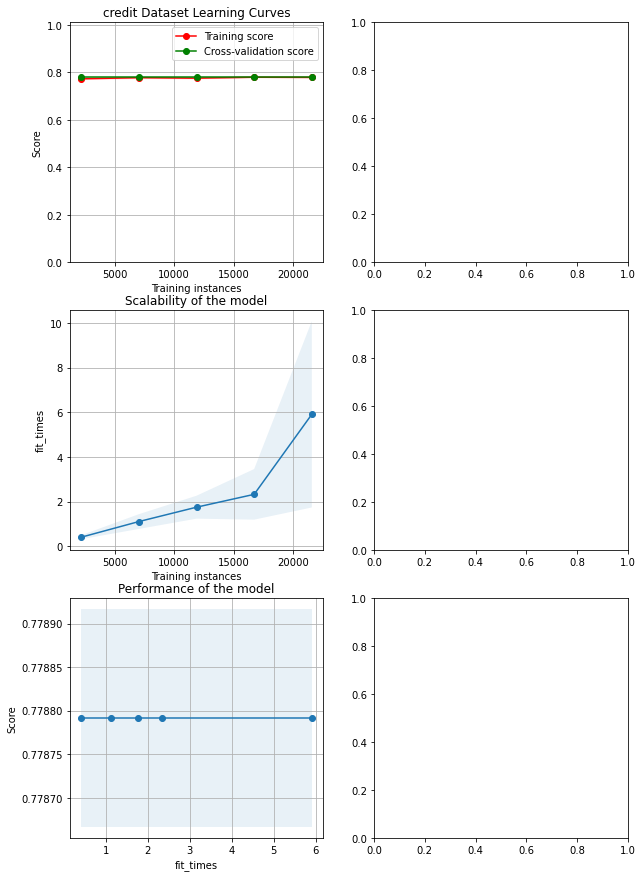

In [56]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = creditx_train, credity_train

title = "credit Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### PCA & EM PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [57]:
# Make Predictions on credit Dataset
print("\n credit Dataset Predictions Results")
best_credit_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_credit_model.fit(creditx_train, credity_train)
credity_predictions = best_credit_model.predict(creditx_test)
print(classification_report(credity_test, credity_predictions,digits=5))
print(confusion_matrix(credity_test, credity_predictions))


 credit Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77883   1.00000   0.87567      4673
           1    0.00000   0.00000   0.00000      1327

    accuracy                        0.77883      6000
   macro avg    0.38942   0.50000   0.43783      6000
weighted avg    0.60658   0.77883   0.68200      6000

[[4673    0]
 [1327    0]]


### ICA

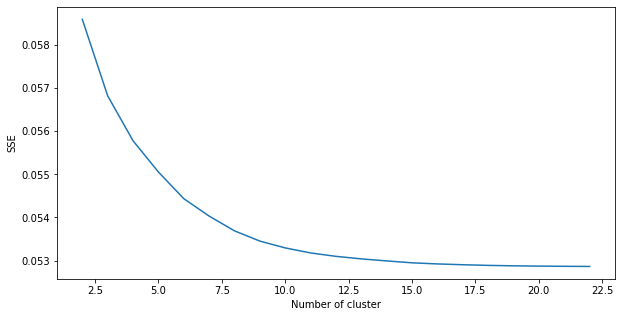

In [58]:
rc_errors = {}
for dim in dims_credit:
    ica = FastICA(n_components=dim, random_state=44)
    x_prime = ica.fit_transform(creditX)
    
    # reconstruction
    A = np.linalg.pinv(ica.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(creditX, reconstructed)    
    rc_errors[dim] = rc_err
#     print(dim, ": ", rc_err)
plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [62]:
comp = 15
ica = FastICA(n_components=comp, random_state=44, max_iter=1000)
ica_result = ica.fit_transform(creditX)
for i in range(comp):
    field_name = "ica-"+str(i)
    creditX_df[field_name] = ica_result[:,i]
    creditdata_concat[field_name] = ica_result[:,i]
creditX_ica_15 = ica_result

In [61]:
ica_result.shape

(30000, 15)

In [63]:
creditX_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,pca-0,pca-1,pca-2,pca-3,pca-4,pca-5,pca-6,pca-7,pca-8,pca-9,pca-10,pca-11,pca-12,ica-0,ica-1,ica-2,ica-3,ica-4,ica-5,ica-6,ica-7,ica-8,ica-9,ica-10,ica-11,ica-12,ica-13,ica-14
0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,-0.404232,-0.008005,-0.002597,-0.212566,-0.211858,0.142288,-0.353981,-0.055854,-0.037792,0.047794,0.098949,0.061357,0.008969,-0.002423,-0.023324,0.002333,0.003610,0.009795,0.010731,-0.000405,-0.006699,0.003607,-0.006410,0.004532,0.000939,-0.002267,-0.004093,0.001066
1,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,-0.391889,0.209224,-0.196988,-0.063890,-0.009020,0.000373,0.104670,-0.040404,0.036161,0.249256,0.028769,0.093556,-0.011375,-0.001622,-0.011203,-0.017727,0.005942,0.001854,-0.001861,-0.002345,0.001182,-0.005404,0.001946,0.004814,0.001220,-0.000046,0.018250,0.001318
2,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,-0.392642,0.084095,-0.126567,-0.077123,0.080733,-0.050136,0.021148,0.006008,0.000249,0.006144,0.001706,0.000031,-0.002720,-0.000767,0.000429,-0.000425,0.002916,-0.003635,-0.000612,-0.000493,0.000734,-0.004260,-0.001716,0.004699,-0.000131,0.000354,0.001021,0.000964
3,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,-0.394038,0.068885,0.154030,-0.108658,-0.085688,0.014440,0.002314,0.077498,0.005925,0.001265,0.001589,-0.000635,-0.005089,-0.000242,0.000552,-0.000458,0.001436,0.001535,-0.000716,0.001652,0.000891,0.005772,-0.006018,0.004450,0.001074,0.001960,0.000994,0.000895
4,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,0.0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.610813,-0.089679,0.334445,-0.141113,0.074264,-0.165212,0.070620,0.116729,0.010839,0.046725,0.077771,0.028073,0.007249,0.003419,-0.005306,-0.000633,0.002358,-0.010292,-0.001278,0.004696,0.007496,0.008780,-0.004098,-0.007493,0.000733,-0.003961,0.006985,0.001084


<AxesSubplot:xlabel='ica-0', ylabel='ica-1'>

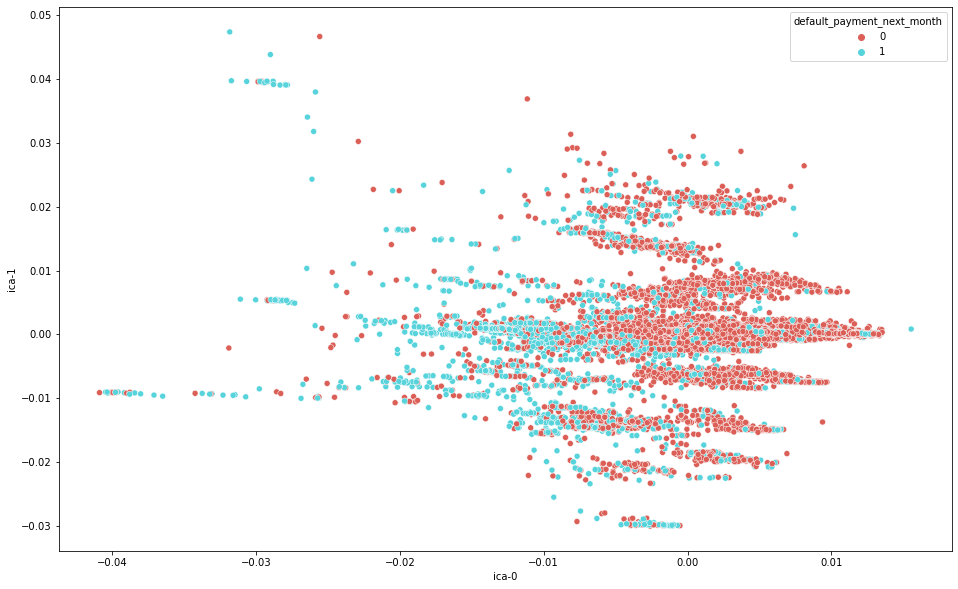

In [64]:
rndperm = np.random.permutation(creditdata_concat.shape[0])
plt.figure(figsize=(16,10))
sns.scatterplot(data=creditdata_concat, x="ica-0", y="ica-1", hue="default_payment_next_month",palette=sns.color_palette("hls",2))

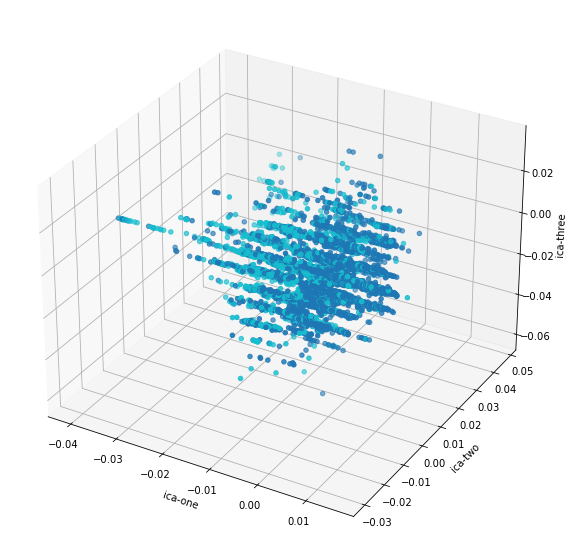

In [65]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=creditdata_concat.loc[rndperm,:]["ica-0"], 
    ys=creditdata_concat.loc[rndperm,:]["ica-1"], 
    zs=creditdata_concat.loc[rndperm,:]["ica-2"], 
    c=creditdata_concat.loc[rndperm,:]["default_payment_next_month"], 
    cmap='tab10'
)
ax.set_xlabel('ica-one')
ax.set_ylabel('ica-two')
ax.set_zlabel('ica-three')
plt.show()

### K-MEANS CLUSTERING AFTER APPLYING ICA

In [66]:
creditX_ica_15.shape

(30000, 15)

For n_clusters=2, The Silhouette Coefficient is 0.09527731628548745
For n_clusters=2, The homogeneity_score is 0.001500777519188931
For n_clusters=3, The Silhouette Coefficient is 0.10188951163171667
For n_clusters=3, The homogeneity_score is 0.02737750104259355
For n_clusters=4, The Silhouette Coefficient is 0.10028963715607556
For n_clusters=4, The homogeneity_score is 0.0028749932038538107
For n_clusters=5, The Silhouette Coefficient is 0.09597835625771103
For n_clusters=5, The homogeneity_score is 0.02406706116232526
For n_clusters=6, The Silhouette Coefficient is 0.10437761776618848
For n_clusters=6, The homogeneity_score is 0.035149734090745205
For n_clusters=7, The Silhouette Coefficient is 0.09170611891952819
For n_clusters=7, The homogeneity_score is 0.023807479624653634
For n_clusters=8, The Silhouette Coefficient is 0.09420555842046718
For n_clusters=8, The homogeneity_score is 0.03154832358521298
For n_clusters=9, The Silhouette Coefficient is 0.09999318209938202
For n_clus

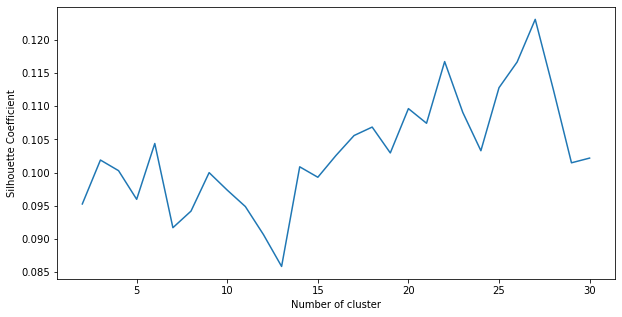

In [67]:
silh = {}
homog = {}
for cluster in list(range(2,31,1)):
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=44, n_jobs=-2).fit(creditX_ica_15)
    label = kmeans.labels_
    sil_coeff = silhouette_score(creditX_ica_15, label, metric='euclidean')
    homog_score = homogeneity_score(creditY, label)
    silh[cluster] = sil_coeff
    homog[cluster] = homog_score
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

### EXPECTATION MAXIMIZATION AFTER APPLYING ICA

For n_clusters=2, The Silhouette Coefficient is 0.1514582095911303
For n_clusters=2, The homogeneity_score is 0.01003735774459801
For n_clusters=2, The log_likelihood score is 59.290994503122846
For n_clusters=3, The Silhouette Coefficient is 0.025401945499651142
For n_clusters=3, The homogeneity_score is 0.039198077356099155
For n_clusters=3, The log_likelihood score is 62.882928701561326
For n_clusters=4, The Silhouette Coefficient is 0.02308454788873843
For n_clusters=4, The homogeneity_score is 0.04024575156835047
For n_clusters=4, The log_likelihood score is 63.53855511165617
For n_clusters=5, The Silhouette Coefficient is -0.0360211948255546
For n_clusters=5, The homogeneity_score is 0.055074354524672596
For n_clusters=5, The log_likelihood score is 63.963230488206314
For n_clusters=6, The Silhouette Coefficient is -0.01976725463532498
For n_clusters=6, The homogeneity_score is 0.10785994371643105
For n_clusters=6, The log_likelihood score is 64.19985196977103
For n_clusters=7, T

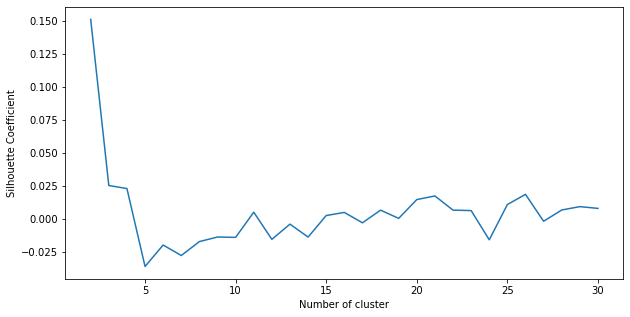

In [68]:
silh_EM = {}
homog_EM = {}
log_likelihood_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=44, 
                          n_init=5).fit(creditX_ica_15)
    label = gmm.predict(creditX_ica_15)
    sil_coeff = silhouette_score(creditX_ica_15, label, metric='euclidean')
    homog_score = homogeneity_score(creditY, label)
    silh_EM[cluster] = sil_coeff
    homog_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(creditX_ica_15)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
    print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_EM[cluster]))

    
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

### NEURAL NETWORK AFTER APPLYING ICA

#### SPLIT ICA Data into train and test

In [69]:
creditX_ica_15.shape

(30000, 15)

In [71]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

creditX_ica_15 = pd.DataFrame(creditX_ica_15, columns = ['Column_A','Column_B','Column_C','Column_D','Column_E','Column_F','Column_G','Column_H','Column_I','Column_J','Column_K','Column_L','Column_M','Column_N','Column_O'])
creditY_df = pd.DataFrame(creditY)

# Splitting credit Dataset
sss.get_n_splits(creditX_ica_15, creditY_df)
for train_index, test_index in sss.split(creditX_ica_15, creditY_df):
    creditx_train, creditx_test = creditX_ica_15.loc[train_index], creditX_ica_15.loc[test_index]
    credity_train, credity_test = creditY_df.loc[train_index], creditY_df.loc[test_index]

#### ICA LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

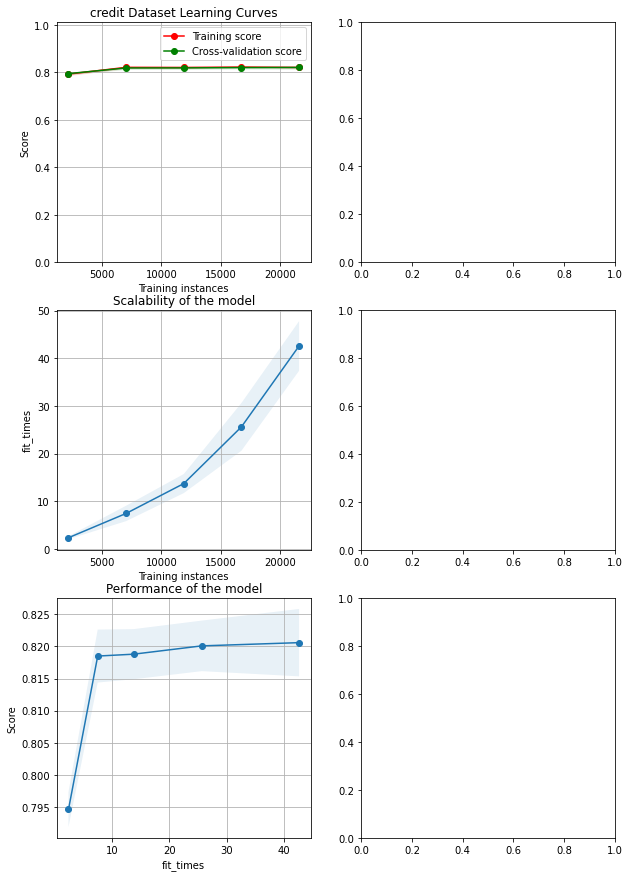

In [72]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = creditx_train, credity_train

title = "credit Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### ICA PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [73]:
# Make Predictions on credit Dataset
print("\n credit Dataset Predictions Results")
best_credit_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_credit_model.fit(creditx_train, credity_train)
credity_predictions = best_credit_model.predict(creditx_test)
print(classification_report(credity_test, credity_predictions,digits=5))
print(confusion_matrix(credity_test, credity_predictions))


 credit Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.83665   0.95249   0.89082      4673
           1    0.67353   0.34514   0.45640      1327

    accuracy                        0.81817      6000
   macro avg    0.75509   0.64882   0.67361      6000
weighted avg    0.80058   0.81817   0.79474      6000

[[4451  222]
 [ 869  458]]


### NEURAL NETWORK AFTER APPLYING ICA AND KMEANS

#### OBTAIN ICA & KMEANS DATA

In [74]:
kmeans = KMeans(n_clusters=22, n_init=50, max_iter=1000, random_state=44, 
                    n_jobs=-2).fit(creditX_ica_15)
label = kmeans.labels_


In [75]:
creditX_ica_kmeans = label.reshape(creditX_ica_15.shape[0],1)
creditX_ica_kmeans = pd.DataFrame(creditX_ica_kmeans)

#### SPLIT ICA & KMEANS Data into train and test

In [76]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting credit Dataset
sss.get_n_splits(creditX_ica_kmeans, creditY)
for train_index, test_index in sss.split(creditX_ica_kmeans, creditY):
    creditx_train, creditx_test = creditX_ica_kmeans.loc[train_index], creditX_ica_kmeans.loc[test_index]
    credity_train, credity_test = creditY.loc[train_index], creditY.loc[test_index]

#### ICA & KMEANS LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

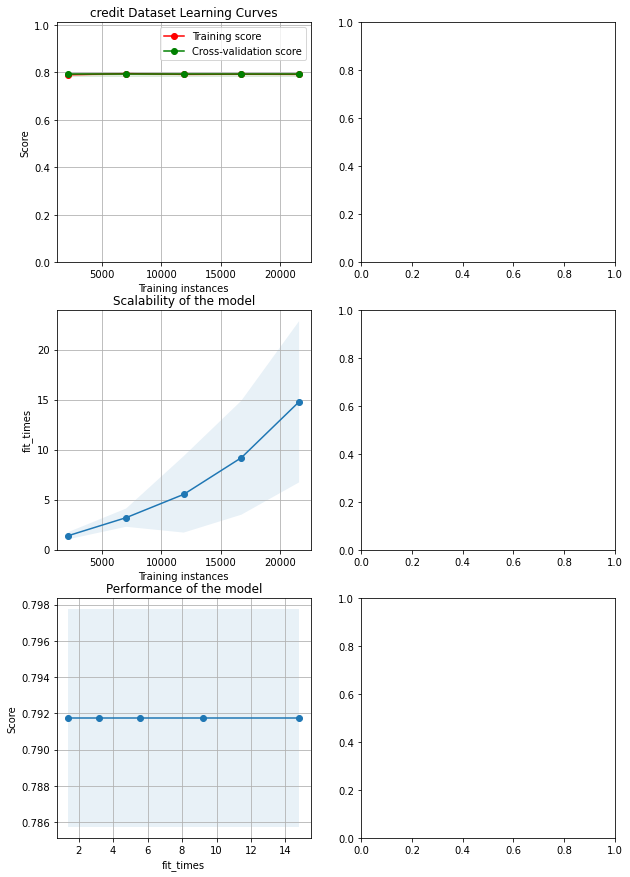

In [77]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = creditx_train, credity_train

title = "credit Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### ICA & KMEANS PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [78]:
# Make Predictions on credit Dataset
print("\n credit Dataset Predictions Results")
best_credit_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_credit_model.fit(creditx_train, credity_train)
credity_predictions = best_credit_model.predict(creditx_test)
print(classification_report(credity_test, credity_predictions,digits=5))
print(confusion_matrix(credity_test, credity_predictions))


 credit Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.80243   0.97346   0.87971      4673
           1    0.62538   0.15599   0.24970      1327

    accuracy                        0.79267      6000
   macro avg    0.71391   0.56473   0.56471      6000
weighted avg    0.76328   0.79267   0.74038      6000

[[4549  124]
 [1120  207]]


### NEURAL NETWORK AFTER APPLYING ICA AND EM

#### OBTAIN iCA & EM DATA

In [79]:
gmm = GaussianMixture(n_components=22, max_iter=100, random_state=44, 
                          n_init=5).fit(creditX_ica_15)
label = gmm.predict(creditX_ica_15)

In [80]:
creditX_ica_em = label.reshape(creditX_ica_15.shape[0],1)
creditX_ica_em = pd.DataFrame(creditX_ica_em)

#### SPLIT ICA & EM Data into train and test

In [81]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting credit Dataset
sss.get_n_splits(creditX_ica_em, creditY)
for train_index, test_index in sss.split(creditX_ica_em, creditY):
    creditx_train, creditx_test = creditX_ica_em.loc[train_index], creditX_ica_em.loc[test_index]
    credity_train, credity_test = creditY.loc[train_index], creditY.loc[test_index]

#### iCA & EM LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

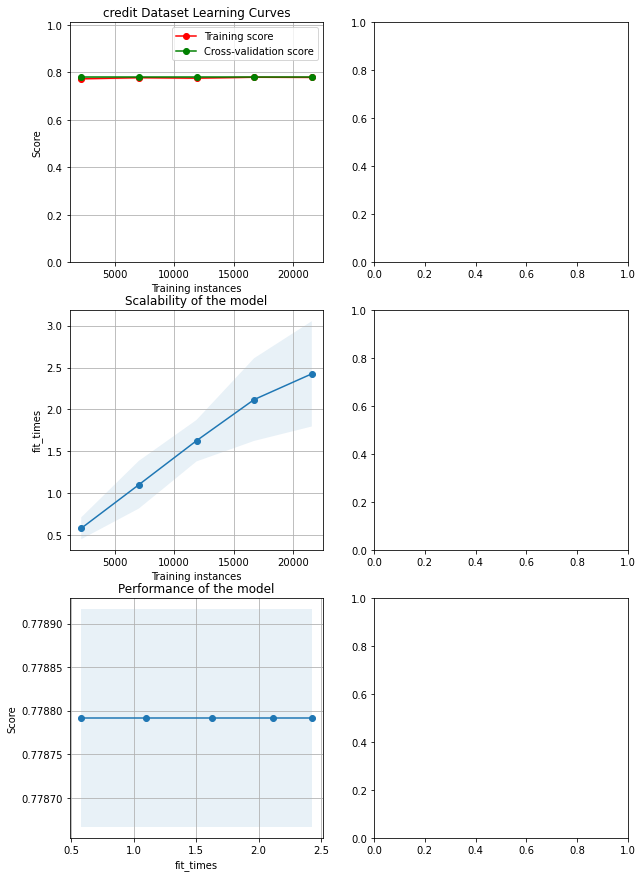

In [82]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = creditx_train, credity_train

title = "credit Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### ICA & EM PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [83]:
# Make Predictions on credit Dataset
print("\n credit Dataset Predictions Results")
best_credit_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_credit_model.fit(creditx_train, credity_train)
credity_predictions = best_credit_model.predict(creditx_test)
print(classification_report(credity_test, credity_predictions,digits=5))
print(confusion_matrix(credity_test, credity_predictions))


 credit Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77883   1.00000   0.87567      4673
           1    0.00000   0.00000   0.00000      1327

    accuracy                        0.77883      6000
   macro avg    0.38942   0.50000   0.43783      6000
weighted avg    0.60658   0.77883   0.68200      6000

[[4673    0]
 [1327    0]]


### RANDOMIZED PROJECTIONS

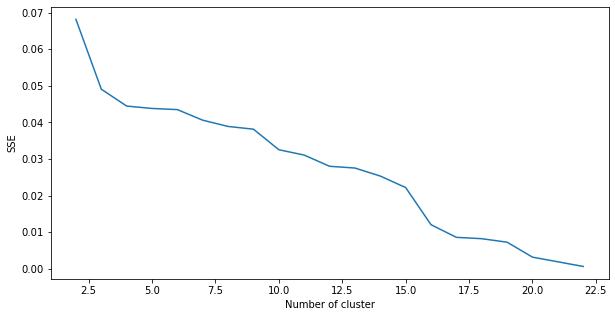

In [84]:
rc_errors = {}
for dim in dims_credit:
    grp = GaussianRandomProjection(n_components=dim, random_state=44)
    x_prime = grp.fit_transform(creditX)
    
    # reconstruction
    A = np.linalg.pinv(grp.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(creditX, reconstructed)    
    rc_errors[dim] = rc_err
#     print(dim, ": ", rc_err)
plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [86]:
comp = 13
grp = GaussianRandomProjection(n_components=comp, random_state=44)
grp_result = grp.fit_transform(creditX)
for i in range(comp):
    field_name = "grp-"+str(i)
    creditX_df[field_name] = grp_result[:,i]
    creditdata_concat[field_name] = grp_result[:,i]
creditX_grp_13 = grp_result

<AxesSubplot:xlabel='grp-0', ylabel='grp-1'>

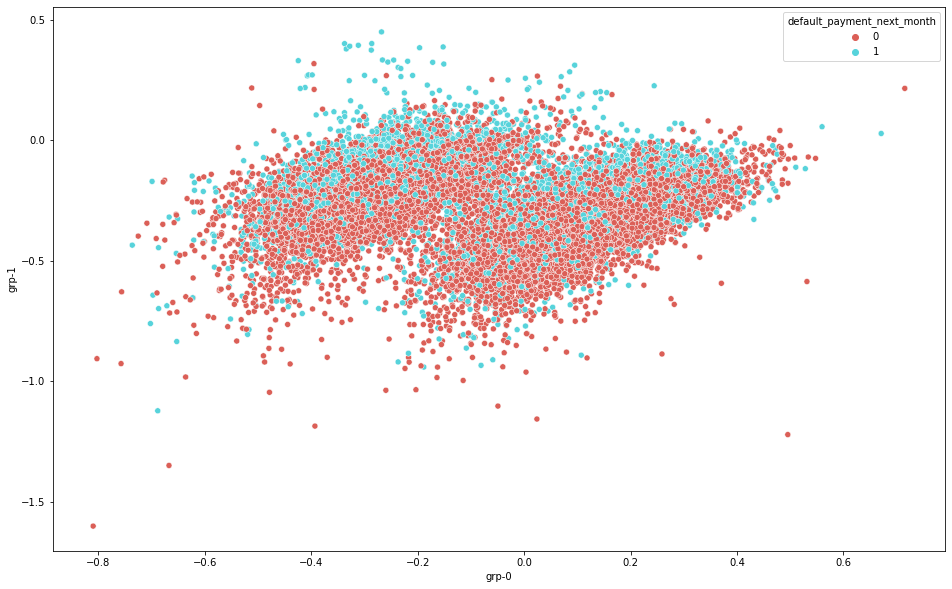

In [87]:
rndperm = np.random.permutation(creditdata_concat.shape[0])
plt.figure(figsize=(16,10))
sns.scatterplot(data=creditdata_concat, x="grp-0", y="grp-1", hue="default_payment_next_month",palette=sns.color_palette("hls",2))

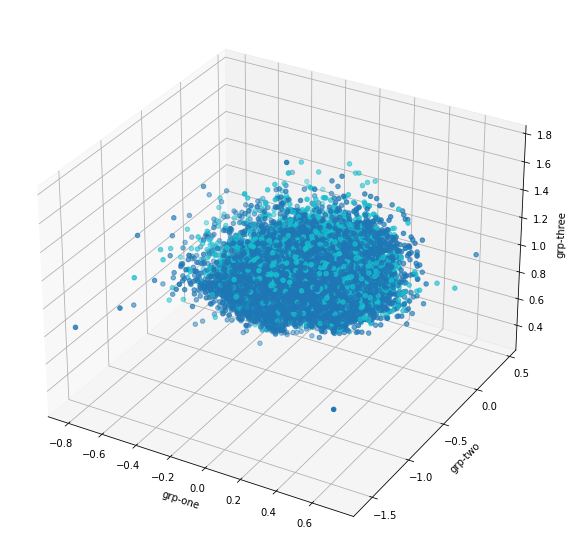

In [88]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=creditdata_concat.loc[rndperm,:]["grp-0"], 
    ys=creditdata_concat.loc[rndperm,:]["grp-1"], 
    zs=creditdata_concat.loc[rndperm,:]["grp-2"], 
    c=creditdata_concat.loc[rndperm,:]["default_payment_next_month"], 
    cmap='tab10'
)
ax.set_xlabel('grp-one')
ax.set_ylabel('grp-two')
ax.set_zlabel('grp-three')
plt.show()

#### K-MEANS CLUSTERING AFTER APPLYING RANDOMIZED PROJECTIONS

In [89]:
creditX_grp_13.shape

(30000, 13)

For n_clusters=2, The Silhouette Coefficient is 0.43813370790090383
For n_clusters=2, The homogeneity_score is 0.0013098927270098165
For n_clusters=3, The Silhouette Coefficient is 0.2737038312562095
For n_clusters=3, The homogeneity_score is 0.01124261753042162
For n_clusters=4, The Silhouette Coefficient is 0.20022554810421594
For n_clusters=4, The homogeneity_score is 0.019486699075236136
For n_clusters=5, The Silhouette Coefficient is 0.20352240741720048
For n_clusters=5, The homogeneity_score is 0.01854817203820309
For n_clusters=6, The Silhouette Coefficient is 0.1980004706511114
For n_clusters=6, The homogeneity_score is 0.016373803571877305
For n_clusters=7, The Silhouette Coefficient is 0.20020506305802604
For n_clusters=7, The homogeneity_score is 0.014377089267126967
For n_clusters=8, The Silhouette Coefficient is 0.1962673046329949
For n_clusters=8, The homogeneity_score is 0.037986038347356296
For n_clusters=9, The Silhouette Coefficient is 0.18706128744814549
For n_cluste

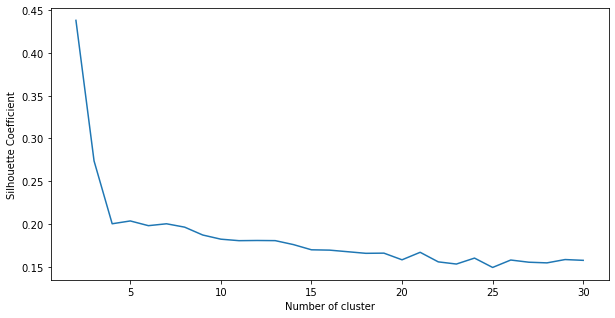

In [90]:
silh = {}
homog = {}
for cluster in list(range(2,31,1)):
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=44, n_jobs=-2).fit(creditX_grp_13)
    label = kmeans.labels_
    sil_coeff = silhouette_score(creditX_grp_13, label, metric='euclidean')
    homog_score = homogeneity_score(creditY, label)
    silh[cluster] = sil_coeff
    homog[cluster] = homog_score
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### EXPECTATION MAXIMIZATION AFTER APPLYING RANDOMIZED PROJECTIONS

For n_clusters=2, The Silhouette Coefficient is 0.4381935223459133
For n_clusters=2, The homogeneity_score is 0.0014952637630506204
For n_clusters=2, The log_likelihood score is 16.113575701105987
For n_clusters=3, The Silhouette Coefficient is 0.24809225958121764
For n_clusters=3, The homogeneity_score is 0.007098739315738218
For n_clusters=3, The log_likelihood score is 18.320334778251482
For n_clusters=4, The Silhouette Coefficient is 0.07990158894800861
For n_clusters=4, The homogeneity_score is 0.011047870051921631
For n_clusters=4, The log_likelihood score is 20.314631919526132
For n_clusters=5, The Silhouette Coefficient is -0.029670210274394034
For n_clusters=5, The homogeneity_score is 0.012902929320057186
For n_clusters=5, The log_likelihood score is 21.589713602777355
For n_clusters=6, The Silhouette Coefficient is -0.03856405144672148
For n_clusters=6, The homogeneity_score is 0.013542674620306163
For n_clusters=6, The log_likelihood score is 21.85940169729585
For n_cluster

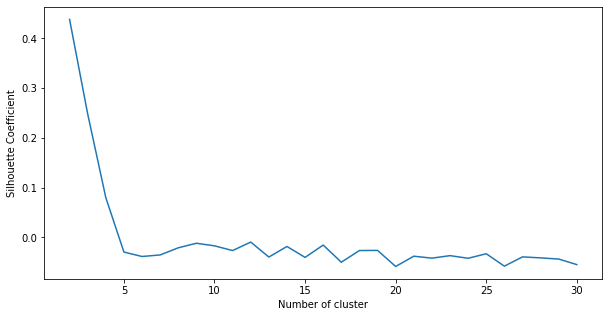

In [91]:
silh_EM = {}
homog_EM = {}
log_likelihood_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=44, 
                          n_init=5).fit(creditX_grp_13)
    label = gmm.predict(creditX_grp_13)
    sil_coeff = silhouette_score(creditX_grp_13, label, metric='euclidean')
    homog_score = homogeneity_score(creditY, label)
    silh_EM[cluster] = sil_coeff
    homog_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(creditX_grp_13)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
    print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_EM[cluster]))

    
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### NEURAL NETWORK AFTER APPLYING RANDOMIZED PROJECTIONS

#### SPLIT RANDOMIZED PROJECTIONS Data into train and test

In [92]:
creditX_grp_13.shape

(30000, 13)

In [94]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

creditX_grp_13 = pd.DataFrame(creditX_grp_13, columns = ['Column_A','Column_B','Column_C','Column_D','Column_E','Column_F','Column_G','Column_H','Column_I','Column_J','Column_K','Column_L','Column_M'])
creditY_df = pd.DataFrame(creditY)

# Splitting credit Dataset
sss.get_n_splits(creditX_grp_13, creditY_df)
for train_index, test_index in sss.split(creditX_grp_13, creditY_df):
    creditx_train, creditx_test = creditX_grp_13.loc[train_index], creditX_grp_13.loc[test_index]
    credity_train, credity_test = creditY_df.loc[train_index], creditY_df.loc[test_index]

#### RANDOMIZED PROJECTIONS LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

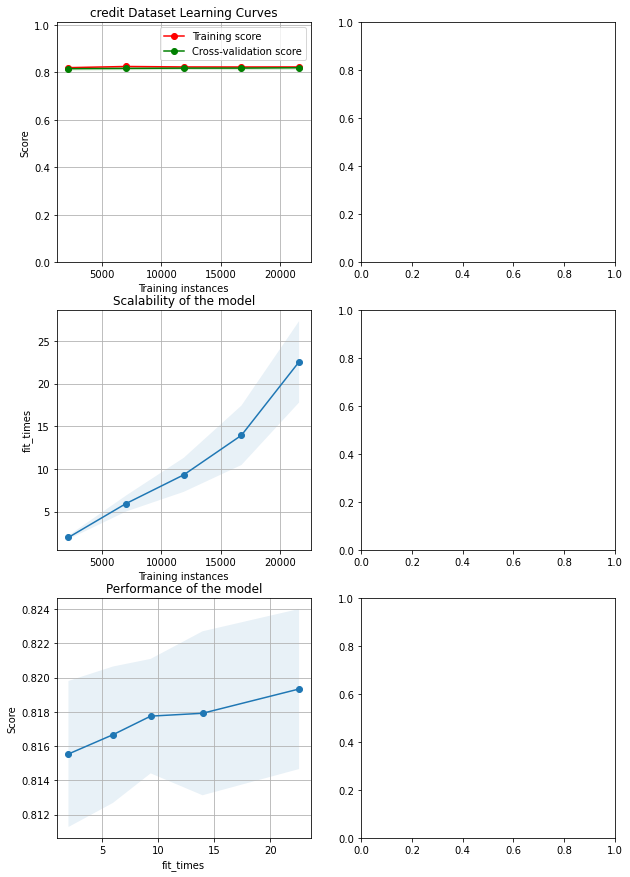

In [95]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = creditx_train, credity_train

title = "credit Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### RANDOMIZED PROJECTIONS PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [96]:
# Make Predictions on credit Dataset
print("\n credit Dataset Predictions Results")
best_credit_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_credit_model.fit(creditx_train, credity_train)
credity_predictions = best_credit_model.predict(creditx_test)
print(classification_report(credity_test, credity_predictions,digits=5))
print(confusion_matrix(credity_test, credity_predictions))


 credit Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.83880   0.94650   0.88940      4673
           1    0.65612   0.35946   0.46446      1327

    accuracy                        0.81667      6000
   macro avg    0.74746   0.65298   0.67693      6000
weighted avg    0.79840   0.81667   0.79542      6000

[[4423  250]
 [ 850  477]]


### NEURAL NETWORK AFTER APPLYING RANDOMIZED PROJECTIONS AND KMEANS

#### OBTAIN RANDOMIZED PROJECTIONS & KMEANS DATA

In [97]:
kmeans = KMeans(n_clusters=22, n_init=50, max_iter=1000, random_state=44, 
                    n_jobs=-2).fit(creditX_grp_13)
label = kmeans.labels_

In [98]:
creditX_grp_kmeans = label.reshape(creditX_grp_13.shape[0],1)
creditX_grp_kmeans = pd.DataFrame(creditX_grp_kmeans)

#### SPLIT RANDOMIZED PROJECTIONS & KMEANS Data into train and test

In [99]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting credit Dataset
sss.get_n_splits(creditX_grp_kmeans, creditY)
for train_index, test_index in sss.split(creditX_grp_kmeans, creditY):
    creditx_train, creditx_test = creditX_grp_kmeans.loc[train_index], creditX_grp_kmeans.loc[test_index]
    credity_train, credity_test = creditY.loc[train_index], creditY.loc[test_index]

#### RANDOMIZED PROJECTIONS & KMEANS LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

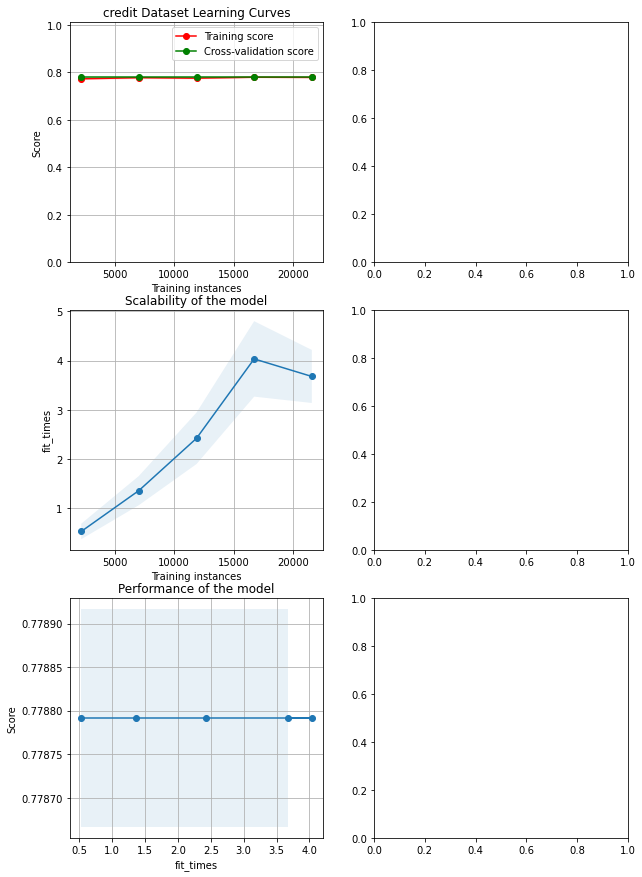

In [100]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = creditx_train, credity_train

title = "credit Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### RANDOMIZED PROJECTIONS & KMEANS PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [101]:
# Make Predictions on credit Dataset
print("\n credit Dataset Predictions Results")
best_credit_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_credit_model.fit(creditx_train, credity_train)
credity_predictions = best_credit_model.predict(creditx_test)
print(classification_report(credity_test, credity_predictions,digits=5))
print(confusion_matrix(credity_test, credity_predictions))


 credit Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77883   1.00000   0.87567      4673
           1    0.00000   0.00000   0.00000      1327

    accuracy                        0.77883      6000
   macro avg    0.38942   0.50000   0.43783      6000
weighted avg    0.60658   0.77883   0.68200      6000

[[4673    0]
 [1327    0]]


### NEURAL NETWORK AFTER APPLYING RANDOMIZED PROJECTIONS AND EM

#### OBTAIN RANDOMIZED PROJECTIONS & EM DATA

In [102]:
gmm = GaussianMixture(n_components=22, max_iter=100, random_state=44, 
                          n_init=5).fit(creditX_grp_13)
label = gmm.predict(creditX_grp_13)

In [103]:
creditX_grp_em = label.reshape(creditX_grp_13.shape[0],1)
creditX_grp_em = pd.DataFrame(creditX_grp_em)

#### SPLIT RANDOMIZED PROJECTIONS & EM Data into train and test

In [104]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting credit Dataset
sss.get_n_splits(creditX_grp_em, creditY)
for train_index, test_index in sss.split(creditX_grp_em, creditY):
    creditx_train, creditx_test = creditX_grp_em.loc[train_index], creditX_grp_em.loc[test_index]
    credity_train, credity_test = creditY.loc[train_index], creditY.loc[test_index]

#### RANDOMIZED PROJECTIONS & EM LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

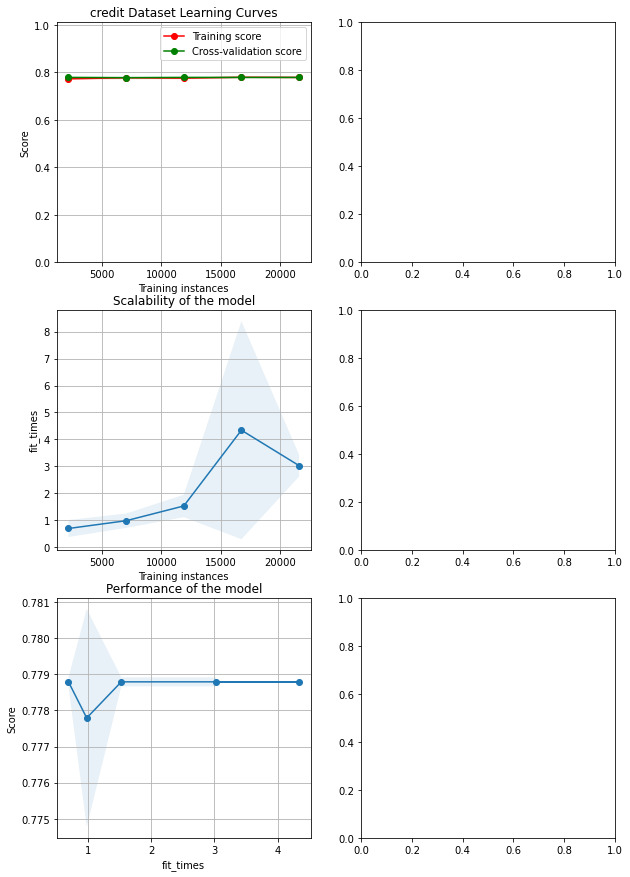

In [105]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = creditx_train, credity_train

title = "credit Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### RANDOMIZED PROJECTIONS & EM PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [106]:
# Make Predictions on credit Dataset
print("\n credit Dataset Predictions Results")
best_credit_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_credit_model.fit(creditx_train, credity_train)
credity_predictions = best_credit_model.predict(creditx_test)
print(classification_report(credity_test, credity_predictions,digits=5))
print(confusion_matrix(credity_test, credity_predictions))


 credit Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77883   1.00000   0.87567      4673
           1    0.00000   0.00000   0.00000      1327

    accuracy                        0.77883      6000
   macro avg    0.38942   0.50000   0.43783      6000
weighted avg    0.60658   0.77883   0.68200      6000

[[4673    0]
 [1327    0]]


### LASSO FEATURE SELECTION

In [107]:
model = FactorAnalysis(n_components=3, random_state=44)
x_prime = model.fit_transform(creditX)

In [108]:
sfm = SelectFromModel(LassoCV(max_iter=1000), threshold=0.1)
sfm.fit(creditX, creditY)
n_features = sfm.transform(creditX).shape

In [109]:
n_features

(30000, 7)

In [110]:
x_prime = sfm.transform(creditX)

In [111]:
sfm = SelectFromModel(LassoCV(max_iter=1000), max_features=8)
sfm.fit(creditX, creditY)
creditX_8_lasso = sfm.transform(creditX)

In [112]:
creditX_8_lasso.shape

(30000, 8)

#### K-MEANS CLUSTERING AFTER LASSO FEATURE SELECTION

For n_clusters=2, The Silhouette Coefficient is 0.40141084689995316
For n_clusters=2, The homogeneity_score is 0.010293774712848563
For n_clusters=3, The Silhouette Coefficient is 0.44922723344497767
For n_clusters=3, The homogeneity_score is 0.09073442062716171
For n_clusters=4, The Silhouette Coefficient is 0.4775330765331769
For n_clusters=4, The homogeneity_score is 0.09408323304240851
For n_clusters=5, The Silhouette Coefficient is 0.4925303013919301
For n_clusters=5, The homogeneity_score is 0.1336738834487092
For n_clusters=6, The Silhouette Coefficient is 0.46081692355908843
For n_clusters=6, The homogeneity_score is 0.1308412667727535
For n_clusters=7, The Silhouette Coefficient is 0.49651405769411167
For n_clusters=7, The homogeneity_score is 0.139574144651234
For n_clusters=8, The Silhouette Coefficient is 0.5337532432401619
For n_clusters=8, The homogeneity_score is 0.14146513531258453
For n_clusters=9, The Silhouette Coefficient is 0.5385889765295229
For n_clusters=9, The 

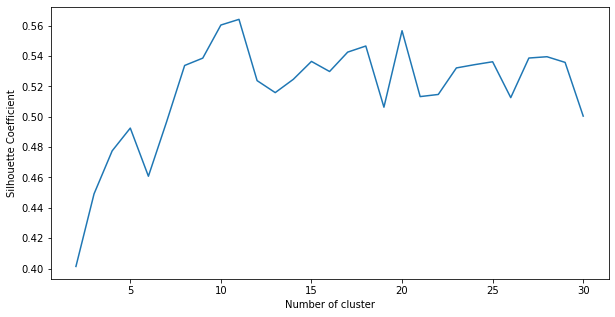

In [113]:
silh = {}
homog = {}
for cluster in list(range(2,31,1)):
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=44, n_jobs=-2).fit(creditX_8_lasso)
    label = kmeans.labels_
    sil_coeff = silhouette_score(creditX_8_lasso, label, metric='euclidean')
    homog_score = homogeneity_score(creditY, label)
    silh[cluster] = sil_coeff
    homog[cluster] = homog_score
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### EXPECTATION MAXIMIZATION AFTER LASSO FEATURE SELECTION

For n_clusters=2, The Silhouette Coefficient is 0.0773852817395362
For n_clusters=2, The homogeneity_score is 0.013257008516048161
For n_clusters=2, The log_likelihood score is 20.078753135607293
For n_clusters=3, The Silhouette Coefficient is 0.13209449360521378
For n_clusters=3, The homogeneity_score is 0.05768845816875919
For n_clusters=3, The log_likelihood score is 24.953001488282375
For n_clusters=4, The Silhouette Coefficient is 0.12751687588205446
For n_clusters=4, The homogeneity_score is 0.05804661149671853
For n_clusters=4, The log_likelihood score is 25.721282640243267
For n_clusters=5, The Silhouette Coefficient is 0.2917095307405566
For n_clusters=5, The homogeneity_score is 0.10617843848820388
For n_clusters=5, The log_likelihood score is 27.2017977078197
For n_clusters=6, The Silhouette Coefficient is 0.28498916358950094
For n_clusters=6, The homogeneity_score is 0.10639737227719587
For n_clusters=6, The log_likelihood score is 27.599528550981034
For n_clusters=7, The S

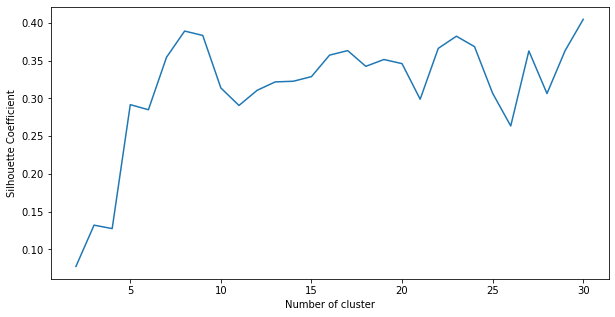

In [114]:
silh_EM = {}
homog_EM = {}
log_likelihood_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=44, 
                          n_init=5).fit(creditX_8_lasso)
    label = gmm.predict(creditX_8_lasso)
    sil_coeff = silhouette_score(creditX_8_lasso, label, metric='euclidean')
    homog_score = homogeneity_score(creditY, label)
    silh_EM[cluster] = sil_coeff
    homog_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(creditX_8_lasso)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
    print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_EM[cluster]))

    
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### NEURAL NETWORK AFTER LASSO FEATURE SELECTION

#### SPLIT LASSO FEATURE SELECTION Data into train and test

In [115]:
creditX_8_lasso.shape

(30000, 8)

In [116]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

creditX_8_lasso = pd.DataFrame(creditX_8_lasso, columns = ['Column_A','Column_B','Column_C','Column_D','Column_E','Column_F','Column_G','Column_H'])
creditY_df = pd.DataFrame(creditY)

# Splitting credit Dataset
sss.get_n_splits(creditX_8_lasso, creditY_df)
for train_index, test_index in sss.split(creditX_8_lasso, creditY_df):
    creditx_train, creditx_test = creditX_8_lasso.loc[train_index], creditX_8_lasso.loc[test_index]
    credity_train, credity_test = creditY_df.loc[train_index], creditY_df.loc[test_index]

#### LASSO FEATURE SELECTION LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

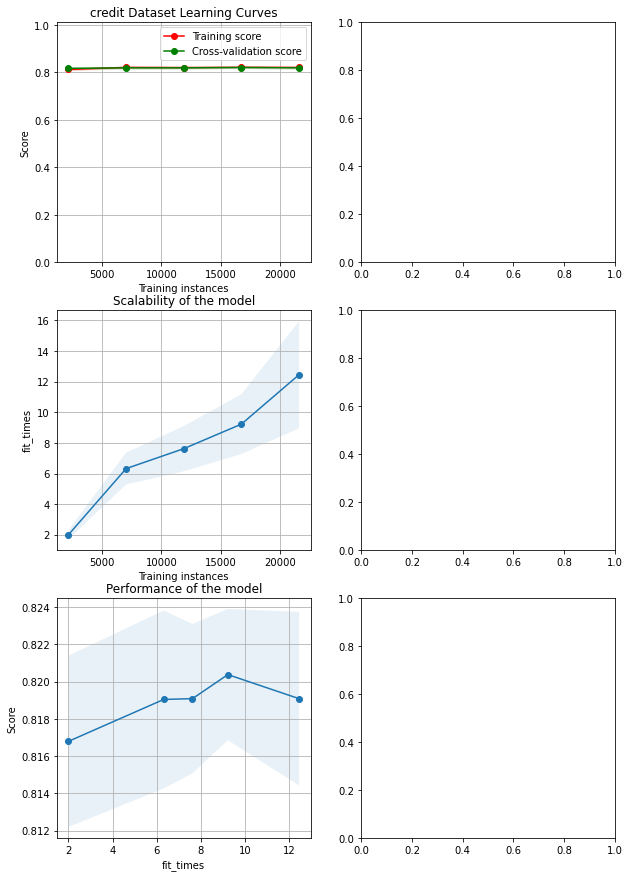

In [117]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = creditx_train, credity_train

title = "credit Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### LASSO FEATURE SELECTION PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [118]:
# Make Predictions on credit Dataset
print("\n credit Dataset Predictions Results")
best_credit_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_credit_model.fit(creditx_train, credity_train)
credity_predictions = best_credit_model.predict(creditx_test)
print(classification_report(credity_test, credity_predictions,digits=5))
print(confusion_matrix(credity_test, credity_predictions))


 credit Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.84396   0.93751   0.88828      4673
           1    0.63906   0.38960   0.48408      1327

    accuracy                        0.81633      6000
   macro avg    0.74151   0.66356   0.68618      6000
weighted avg    0.79864   0.81633   0.79889      6000

[[4381  292]
 [ 810  517]]


### NEURAL NETWORK AFTER LASSO FEATURE SELECTION AND KMEANS

#### OBTAIN LASSO FEATURE SELECTION & KMEANS DATA

In [119]:
kmeans = KMeans(n_clusters=22, n_init=50, max_iter=1000, random_state=44, 
                    n_jobs=-2).fit(creditX_8_lasso)
label = kmeans.labels_

In [120]:
creditX_lasso_kmeans = label.reshape(creditX_8_lasso.shape[0],1)
creditX_lasso_kmeans = pd.DataFrame(creditX_lasso_kmeans)

#### SPLIT LASSO FEATURE SELECTION & KMEANS Data into train and test

In [121]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting credit Dataset
sss.get_n_splits(creditX_lasso_kmeans, creditY)
for train_index, test_index in sss.split(creditX_lasso_kmeans, creditY):
    creditx_train, creditx_test = creditX_lasso_kmeans.loc[train_index], creditX_lasso_kmeans.loc[test_index]
    credity_train, credity_test = creditY.loc[train_index], creditY.loc[test_index]

#### LASSO FEATURE SELECTION & KMEANS LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

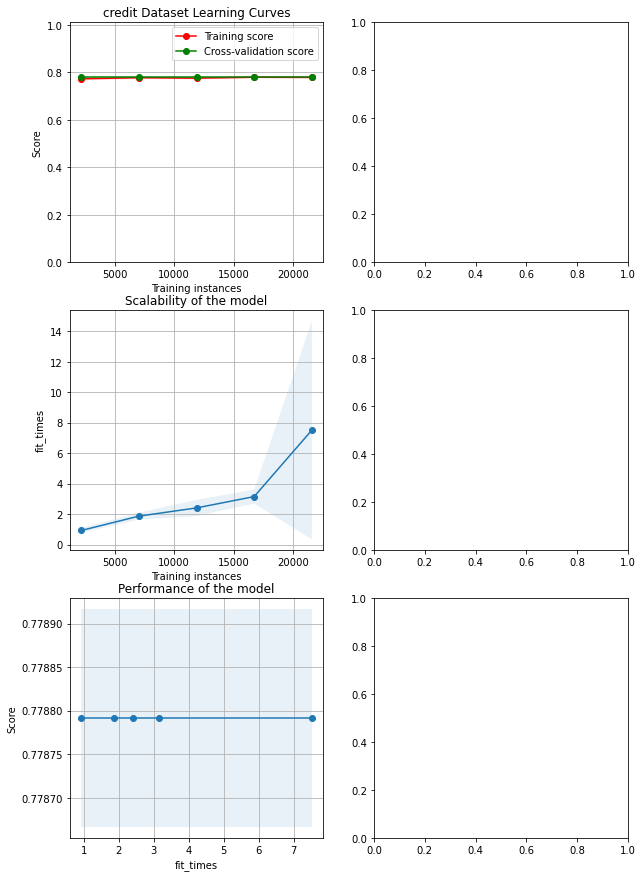

In [122]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = creditx_train, credity_train

title = "credit Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### LASSO FEATURE SELECTION & KMEANS PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [123]:
# Make Predictions on credit Dataset
print("\n credit Dataset Predictions Results")
best_credit_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_credit_model.fit(creditx_train, credity_train)
credity_predictions = best_credit_model.predict(creditx_test)
print(classification_report(credity_test, credity_predictions,digits=5))
print(confusion_matrix(credity_test, credity_predictions))


 credit Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77883   1.00000   0.87567      4673
           1    0.00000   0.00000   0.00000      1327

    accuracy                        0.77883      6000
   macro avg    0.38942   0.50000   0.43783      6000
weighted avg    0.60658   0.77883   0.68200      6000

[[4673    0]
 [1327    0]]


### NEURAL NETWORK AFTER LASSO FEATURE SELECTION AND EM

#### OBTAIN LASSO FEATURE SELECTION & EM DATA

In [124]:
gmm = GaussianMixture(n_components=22, max_iter=100, random_state=44, 
                          n_init=5).fit(creditX_8_lasso)
label = gmm.predict(creditX_8_lasso)

In [125]:
creditX_lasso_em = label.reshape(creditX_8_lasso.shape[0],1)
creditX_lasso_em = pd.DataFrame(creditX_lasso_em)

#### SPLIT LASSO FEATURE SELECTION  & EM Data into train and test

In [126]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting credit Dataset
sss.get_n_splits(creditX_lasso_em, creditY)
for train_index, test_index in sss.split(creditX_lasso_em, creditY):
    creditx_train, creditx_test = creditX_lasso_em.loc[train_index], creditX_lasso_em.loc[test_index]
    credity_train, credity_test = creditY.loc[train_index], creditY.loc[test_index]

#### LASSO FEATURE SELECTION & EM LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

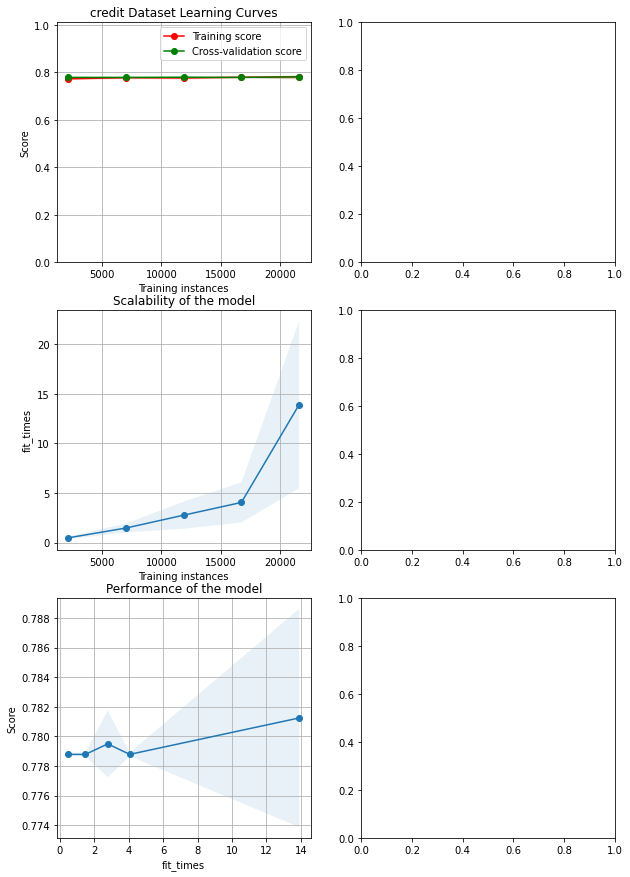

In [127]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = creditx_train, credity_train

title = "credit Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### LASSO FEATURE SELECTION & EM PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [128]:
# Make Predictions on credit Dataset
print("\n credit Dataset Predictions Results")
best_credit_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_credit_model.fit(creditx_train, credity_train)
credity_predictions = best_credit_model.predict(creditx_test)
print(classification_report(credity_test, credity_predictions,digits=5))
print(confusion_matrix(credity_test, credity_predictions))


 credit Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.80980   0.96576   0.88093      4673
           1    0.62529   0.20121   0.30445      1327

    accuracy                        0.79667      6000
   macro avg    0.71754   0.58348   0.59269      6000
weighted avg    0.76899   0.79667   0.75343      6000

[[4513  160]
 [1060  267]]
